In [177]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dtw import dtw
from sklearn.preprocessing import MinMaxScaler


In [178]:
data_path = "dataset/"
file_list = os.listdir(data_path)
file_list_csv = [file for file in file_list if file.endswith(".csv")]

dtA = pd.read_csv(data_path+"bitcoin.csv")
dtB = pd.read_csv(data_path+"HymanMinsky.csv")

dtA['Date'] = dtA['Date'].map(pd.to_datetime)
dtB.set_index(dtB['x'])

dtA = np.array(dtA['Close']).reshape(-1)
dtB = np.array(dtB['y']).reshape(-1)

interp_ind = np.arange(0, len(dtA),len(dtA)/float(len(dtB)))
interp_dtB = np.interp(np.arange(0,len(dtA),1),interp_ind,dtB).reshape(-1,1)
dtA = dtA.reshape(-1,1)
dtB = dtB.reshape(-1,1)

In [179]:
mns = MinMaxScaler()

dtA = mns.fit_transform(dtA)
dtB = mns.fit_transform(dtB)
interp_dtB = mns.fit_transform(interp_dtB)
print(dtA.shape)
print(dtB.shape)
print(interp_dtB.shape)

(1743, 1)
(65, 1)
(1743, 1)


In [184]:
# compare dtw with euclidean 
euc_dist, path_int = fastdtw(dtA, interp_dtB, dist=euclidean)
dtw_dist, path = fastdtw(dtA, dtB, dist=euclidean)
d, cost_matrix, acc_cost_matrix, path_ = dtw(dtA, dtB, dist=euclidean)

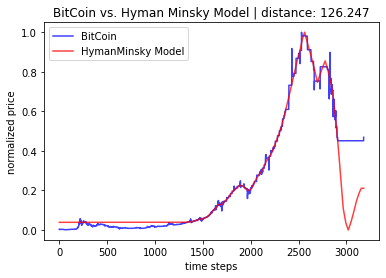

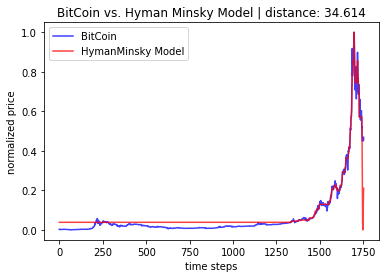

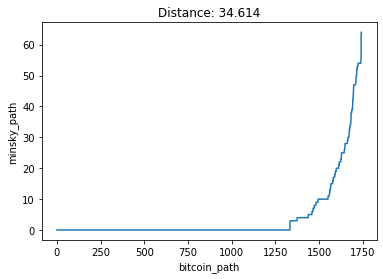

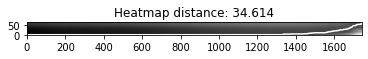

In [185]:
# # Interpolation
# fig, ax = plt.subplots()
# ax.plot(dtA, color='r', label='Bitcoin', alpha=0.75)
# ax.plot(interp_dtB, color='b', label='Hymanminsky model', alpha=0.75)
# ax.legend()
# ax.set_title("Bitcoin vs Hyman Minsky Model(interp) | distance: {}"
#             .format(round(euc_dist, 3)))
# ax.set_xlabel("time steps")
# ax.set_ylabel("normalized price")

# plt.show()

fig, ax = plt.subplots()

int_dtA_df = pd.DataFrame(data=dtA)
interp_dtB_df = pd.DataFrame(data=interp_dtB)

ax.plot([int_dtA_df.iloc[v] for v in [p[0] for p in path_int]],
        color='b', label='BitCoin', alpha=0.75)
ax.plot([interp_dtB_df.iloc[v] for v in [p[1] for p in path_int]],
        color='r', label='HymanMinsky Model', alpha=0.75)
ax.legend()
# euc_dist = np.float(euc_dist)
ax.set_title("BitCoin vs. Hyman Minsky Model | distance: {}"
             .format(round(euc_dist, 3)))
ax.set_xlabel("time steps")
ax.set_ylabel("normalized price")
plt.show()

fig, ax = plt.subplots()

dtA_df = pd.DataFrame(data=dtA)
dtB_df = pd.DataFrame(data=dtB)

ax.plot([dtA_df.iloc[v] for v in [p[0] for p in path]],
        color='b', label='BitCoin', alpha=0.75)
ax.plot([dtB_df.iloc[v] for v in [p[1] for p in path]],
        color='r', label='HymanMinsky Model', alpha=0.75)
ax.legend()
euc_dist = np.float(euc_dist)
ax.set_title("BitCoin vs. Hyman Minsky Model | distance: {}"
             .format(round(dtw_dist, 3)))
ax.set_xlabel("time steps")
ax.set_ylabel("normalized price")
plt.show()

dtA_path = [p[0] for p in path]
dtB_path = [p[1] for p in path]

fig, ax = plt.subplots()
ax.plot(dtA_path, dtB_path)
ax.set_title("Distance: {}".format(round(dtw_dist, 3)))
# plt.plot(arraysA_path, arraysB_path)
ax.set_xlabel("bitcoin_path")
ax.set_ylabel("minsky_path")
plt.show()

plt.title("Heatmap distance: {}".format(round(d,3)))
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path_[0], path_[1], 'w')
plt.show()

In [153]:
dtA = dtA.reshape(-1)
interp_dtB = interp_dtB.reshape(-1)
print(interp_dtB.shape)
print("interp_Corrcoef: \n",np.corrcoef(dtA, interp_dtB))

(1743,)
interp_Corrcoef: 
 [[ 1.         -0.21879006]
 [-0.21879006  1.        ]]


In [154]:
dtB = dtB.reshape(-1)
dtB_dtw = [dtB[p] for p in path_[1]]
print("Dtw_Corrcoef:\n",np.corrcoef(dtA,dtB_dtw[:1743]))

Dtw_Corrcoef:
 [[1.         0.99196582]
 [0.99196582 1.        ]]


In [155]:
def paa(arr, sections):
    try:
        assert arr.shape[0] != sections
    except AssertionError as e:
        return np.copy(arr)
    else:
        if arr.shape[0] % sections == 0:
            sectionarr = np.array_split(arr, sections)
            res = np.array([item.mean() for item in sectionarr])
#             res = np.array((
#                 sample for item in res for sample in 
#                 [item.mean()] * item.shape[0])
#             )
        else:
            sectionarr = np.zeros(sections)
            space_size = np.arange(0, arr.shape[0] * sections -1)
            outputIndex = space_size // arr.shape[0]
            inputIndex = space_size // sections
            uniques, nUniques = np.unique(outputIndex, return_counts=True)
            
            res = [arr[indices].sum() / arr.shape[0] for indices in
                   np.split(inputIndex, nUniques.cumsum())[:-1]]
            indices = ([row.mean() for row in np.split(inputIndex, nUniques.cumsum())[:-1]])
    return res


In [168]:
paa_dtA = paa(dtA, 65)
paa_dist, path = fastdtw(paa_dtA, dtB, dist=euclidean)
# from pyts.approximation import  PiecewiseAggregateApproximation
# dtA =  PiecewiseAggregateApproximation(window_size=27).transform(dtA)
print("PAA_Corrcoef:\n",np.corrcoef(paa_dtA,dtB))
# print(dtA.shape)

PAA_Corrcoef:
 [[ 1.         -0.22246798]
 [-0.22246798  1.        ]]


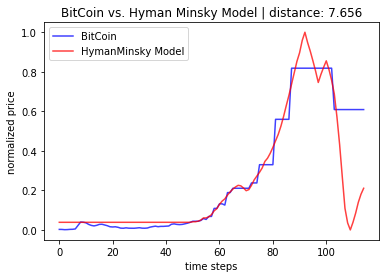

In [169]:
# dtA.reshape(-1,1)
paa_euc_dist_c = euclidean(paa_dtA, dtB)

fig, ax = plt.subplots()

paa_dtA_df = pd.DataFrame(data=paa_dtA)
dtB_df = pd.DataFrame(data=dtB)

ax.plot([paa_dtA_df.iloc[v] for v in [p[0] for p in path]],
        color='b', label='BitCoin', alpha=0.75)
ax.plot([dtB_df.iloc[v] for v in [p[1] for p in path]],
        color='r', label='HymanMinsky Model', alpha=0.75)
ax.legend()
euc_dist = np.float(euc_dist)
ax.set_title("BitCoin vs. Hyman Minsky Model | distance: {}"
             .format(round(paa_dist, 3)))
ax.set_xlabel("time steps")
ax.set_ylabel("normalized price")
plt.show()


[[3.51018480e-02 7.29965038e-02 1.10958695e-01 ... 2.48104179e+01
  2.49876113e+01 2.51948860e+01]
 [6.96720157e-02 7.24648235e-02 1.09895335e-01 ... 9.22337204e+18
  9.22337204e+18 9.22337204e+18]
 [1.04527325e-01 1.07320132e-01 1.10180476e-01 ... 9.22337204e+18
  9.22337204e+18 9.22337204e+18]
 ...
 [1.07905507e+02 9.22337204e+18 9.22337204e+18 ... 9.22337204e+18
  9.22337204e+18 9.22337204e+18]
 [1.08318012e+02 9.22337204e+18 9.22337204e+18 ... 9.22337204e+18
  9.22337204e+18 9.22337204e+18]
 [1.08748230e+02 9.22337204e+18 9.22337204e+18 ... 9.22337204e+18
  9.22337204e+18 9.22337204e+18]]
9.223372036854776e+18
9.223372036854776e+18 
 [(1742, 64), (1741, 64), (1740, 64), (1739, 64), (1738, 64), (1737, 64), (1736, 64), (1735, 64), (1734, 64), (1733, 64), (1732, 64), (1731, 64), (1730, 64), (1729, 64), (1728, 64), (1727, 64), (1726, 64), (1725, 64), (1724, 64), (1723, 64), (1722, 64), (1721, 64), (1720, 64), (1719, 64), (1718, 64), (1717, 64), (1716, 64), (1715, 64), (1714, 64), (1713

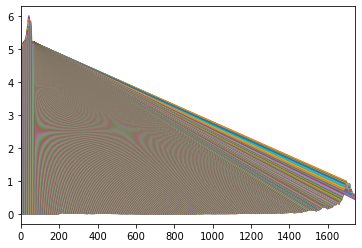

In [164]:

from math import *
import numpy as np
import sys


def DTW(A, B, window=sys.maxsize, d=lambda x, y: abs(x - y)):
    # 비용 행렬 초기화
    A, B = np.array(A), np.array(B)
    M, N = len(A), len(B)
    cost = sys.maxsize * np.ones((M, N))

    # 첫번째 로우,컬럼 채우기
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(A[0], B[j])
    # 나머지 행렬 채우기
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])
    print(cost)

    # 최적 경로 구하기
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key=lambda x: cost[x[0], x[1]])

    path.append((0, 0))
    print(cost[-1,-1])
    return cost[-1, -1], path


def main():
    
    # A = np.random.random(size=6)
    # print(A)
    # B = np.random.random(size=6)
    # print(B)

    cost, path = DTW(dtA, dtB, window = 6)
    print(cost,"\n",path)
    print('Total Distance is ', cost)
    import matplotlib.pyplot as plt
    offset = 5
    plt.xlim([-1, max(len(dtA), len(dtB)) + 1])
    plt.plot(dtA)
    plt.plot(dtB + offset)
    for (x1, x2) in path:
        plt.plot([x1, x2], [dtA[x1], dtB[x2] + offset])
    plt.show()

if __name__ == '__main__':
    main()